In [1]:
from my_plot_tools import plot_confusion_matrix

In [2]:
import pandas as pd
import numpy as np

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [31]:
df_fake = pd.read_csv('./fake_news_set.csv')
df_real = pd.read_csv('./real_news_set.csv').sample(df_fake.shape[0]) # due to imba dataset

In [32]:
df = pd.concat([df_real, df_fake], axis=0).sample(frac=1).reset_index(drop=True)

In [33]:
df.groupby('label').size()

label
0    6822
1    6822
dtype: int64

## Using only Body

In [35]:
vect = CountVectorizer(ngram_range=(1,2))
tfid = TfidfTransformer()

In [36]:
%%time
X = vect.fit_transform(df['body'].astype(str)).copy()
X = tfid.fit_transform(X)
y = df.loc[:, 'label'].copy()

CPU times: user 42.5 s, sys: 1.18 s, total: 43.7 s
Wall time: 39.9 s


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=245)
X_train.shape

(9550, 2521736)

### Naive-Bayes

In [38]:
from sklearn.naive_bayes import MultinomialNB

In [39]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [40]:
nb_model.score(X_test, y_test)

0.6990718124084025

Normalized confusion matrix
[[4.04358354e-01 5.95641646e-01]
 [9.85707245e-04 9.99014293e-01]]


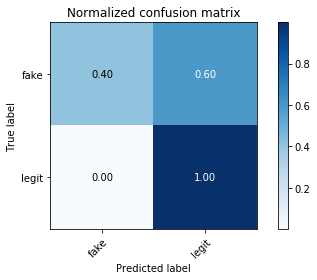

In [41]:
y_pred = nb_model.predict(X_test)

assert y_pred.shape == y_test.shape
plot_confusion_matrix(y_test, y_pred, classes=np.array(['fake', 'legit']), normalize=True,
                      title='Normalized confusion matrix');

### SVM

In [42]:
from sklearn.linear_model import SGDClassifier

In [45]:
svm_model = SGDClassifier();
svm_model.fit(X_train, y_train);

In [46]:
svm_model.score(X_test, y_test)

0.9382022471910112

Normalized confusion matrix
[[0.91912833 0.08087167]
 [0.04238541 0.95761459]]


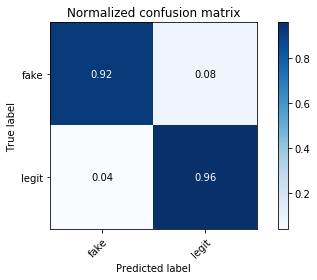

In [47]:
y_pred = svm_model.predict(X_test)

assert y_pred.shape == y_test.shape
plot_confusion_matrix(y_test, y_pred, classes=np.array(['fake', 'legit']), normalize=True,
                      title='Normalized confusion matrix');

- seems like SVM is good, though I wonder wonder why NB performs much worse (need to learn more about how NB works)

### Cross-Validation

In [57]:
from sklearn.model_selection import StratifiedKFold

In [62]:
%%time
N = 15
skf = StratifiedKFold(n_splits=N, random_state=None)
scores = []
for train_index, test_index in skf.split(X, y): 
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index]
    score = svm_model.score(X_test, y_test)
#     print(f"Accuracy: {score}")
    scores.append(score)
print(f"Mean score: {np.mean(score)}\t n-folds: n={N}")

Mean score: 0.98568281938326	 n-folds: n=15
CPU times: user 7.68 s, sys: 613 ms, total: 8.29 s
Wall time: 8.3 s


### GridSearch

In [22]:
from sklearn.model_selection import GridSearchCV